# Data Analysis using Machine Learning

This project consists in the analysis of dataset, through the use of machine learning algorithms, using Python as a programming language. This Jupyter Notebook is organized into sections, which include the steps of the analysis performed and explain very succinctly the procedures performed and decisions taken during the analysis.

## Table of contents

1. [Introduction](#chapter1)
    1. [About Us](#section1_1)
    2. [Data Selection and Context of this Project](#section1_2)
    3. [Credits](#section1_3)
2. [Initial Data Exploration and Preprocessing](#chapter2)
    1. [Importing Packages](#section2_1)
    2. [Importing datasets](#section2_2)
    3. [Exploring the data](#section2_3)
    4. [Protein Descriptors](#section2_4)
    5. [Preprocessing](#section2_5)
3. [Non-Supervised Analysis](#chapter3)
    1. [PCA](#section3_1)
    2. [Kmeans](#section3_2)
    3. [tSNE](#section3_3)
4. [Machine Learning](#chapter4)
    1. [Regression Analysis](#section4_1)
    2. [Binary Analysis](#section4_2)
5. [Deep Learning ](#chapter5)
6. [Conclusions](#chapter6)

<a class="anchor" id="chapter1"></a>

## 1. Introduction

<a class="anchor" id="section1_1"></a>

### 1.1 About Us

This project is part of the subject `Sistemas Inteligentes para a Bioinformática` in the Master in Bioinformatics (University of Minho - 2022/2023).

This project was developed by the following people:
- Alexandre Miguel Magalhães Esperança - pg45963
- André Filipe Pereira da Silva - pg45462
- Mónica Rafaela Machado Leiras - pg45473

The code for this project can be found in [this repository](https://github.com/alexesperanca/SIB_G4/tree/main).

<a class="anchor" id="section1_2"></a>

### 1.2 Data Selection and Context of this Project

For the execution of this project, the dataset of the "Novozymes Enzyme Stability Prediction" Competition on the Kaggle platform was selected. You can view the [Competition and Corresponding Data here](https://www.kaggle.com/competitions/novozymes-enzyme-stability-prediction/data).

The main goal of this competition is to predict the thermostability of enzyme variants. The experimentally measured thermostability (melting temperature) data includes natural sequences, as well as engineered sequences with single or multiple mutations upon the natural sequences.

The test dataset contains experimental melting temperatures of over 2,413 single mutation variants of an enzyme (GenBank: KOC15878.1), obtained by Novozymes A/S. The wild-type amino acid sequence is:

    VPVNPEPDATSVENVALKTGSGDSQSDPIKADLEVKGQSALPFDVDCWAILCKGAPNVLQRVNEKTKNSNRDRSGANKGPFKDPQKWGIKALPPKNPSWSAQDFKSPEEYAFASSLQGGTNAILAPVNLASQNSQGGVLNGFYSANKVAQFDPSKPQQTKGTWFQITKFTGAAGPYCKALGSNDKSVCDKNKNIAGDWGFDPAKWAYQYDEKNNKFNYVGK

For this competition several files were given for the development of this work:

- `train.csv` - the training data, with columns as follows:
  - `seq_id`: unique identifier of each protein variants
  - `protein_sequence`: amino acid sequence of each protein variant. The stability (as measured by tm) of protein is determined by its protein sequence.
  - `pH`: the scale used to specify the acidity of an aqueous solution under which the stability of protein was measured. Stability of the same protein can change at different pH levels.
  - `data_source`: source where the data was published
  - `tm`: target column. Since only the spearman correlation will be used for the evaluation, the correct prediction of the relative order is more important than the absolute tm values. (Higher tm means the protein variant is more stable.)
- `train_updates_20220929.csv` - correction file for train dataset, where some rows have the values ​​of `pH` and `tm` switched, in addition to identifying lines with NaN values. For more details, you can check the [original explanation here](https://www.kaggle.com/competitions/novozymes-enzyme-stability-prediction/discussion/356251)

- `test.csv` - the test data; your task is to predict the target tm for each protein_sequence (indicated by a unique seq_id)

- `sample_submission.csv` - a sample submission file in the correct format, with seq_id values corresponding to test.csv

- `wildtype_structure_prediction_af2.pdb` - the 3 dimensional structure of the enzyme listed above, as predicted by AlphaFold


<a class="anchor" id="section1_3"></a>

### 1.3 Credits

To execute this project, we found some useful code and/or ideas on the forum of the competition. So, we would like to credit the following people with the corresponding notebooks:

[Luca Olga Sharp](https://www.kaggle.com/code/olgashevtsova/enzimes-stability-search-for-the-best-model)

[Alexander Chervov](https://www.kaggle.com/code/alexandervc/novozymes-eda1-ordinalencvisualizationscorrrelat)

[Chris Deotte](https://www.kaggle.com/code/cdeotte/train-data-contains-mutations-like-test-data)

<a class="anchor" id="chapter2"></a>

## 2. Initial Data Exploration and Preprocessing

This step corresponds to the following objectives:
- description and characterization of the assigned data according to the existing documentation/literature;
- brief description of the characteristics of the data available from the initial exploratory analysis;
- description of data preparation and pre-processing steps;
- initial exploratory graphs that illustrate the main characteristics of the data.

<a class="anchor" id="section2_1"></a>

### 2.1 Importing Required Packages

First, we imported the necessary packages. 

In [9]:
#Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from copy import deepcopy
from matplotlib.colors import Normalize
import propy
from propy import *
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from sklearn import preprocessing 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.manifold import TSNE
from sgt import SGT
from keras import metrics
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasRegressor
from keras.layers import Input, Dense, Embedding, Dropout, Conv1D, MaxPooling1D, Flatten, LSTM, concatenate, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from copy import deepcopy
from utils.file_func import *
from utils.models import SupervisedModelOptimization

<a class="anchor" id="section2_2"></a>

### 2.2 Importing datasets

To execute this project, we imported the train dataset named `train.csv`, and also the test dataset `test.csv` that we named `validation`.

In [10]:
#Train dataframe
train = pd.read_csv("train.csv",index_col="seq_id")
#Validation dataframe (test dataset for the competition scoring)
validation = pd.read_csv("test.csv",index_col="seq_id")

In [11]:
train.head()

,protein_sequence,pH,data_source,tm
seq_id,,,,
0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,doi.org/10.1038/s41592-020-0801-4,75.7
1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,doi.org/10.1038/s41592-020-0801-4,50.5
2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,doi.org/10.1038/s41592-020-0801-4,40.5
3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,doi.org/10.1038/s41592-020-0801-4,47.2
4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,doi.org/10.1038/s41592-020-0801-4,49.5


In [12]:
validation.head()

,protein_sequence,pH,data_source
seq_id,,,
31390,VPVNPEPDATSVENVAEKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
31391,VPVNPEPDATSVENVAKKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
31392,VPVNPEPDATSVENVAKTGSGDSQSDPIKADLEVKGQSALPFDVDC...,8,Novozymes
31393,VPVNPEPDATSVENVALCTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
31394,VPVNPEPDATSVENVALFTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes


<a class="anchor" id="section2_3"></a>

### 2.3 Exploring the data

In this step, we explored the data available.


In [13]:
print(f"Train data is divided in {train.shape[0]} samples and {train.shape[1]} features")
print(f"Validation data is divided in {validation.shape[0]} samples and {validation.shape[1]} features")
print(f"Labels for train: {[labels for labels in train.columns]}")

Train data is divided in 31390 samples and 4 features
Validation data is divided in 2413 samples and 3 features
Labels for train: ['protein_sequence', 'pH', 'data_source', 'tm']


In [14]:
train.describe()

,pH,tm
count,31104.000000,31390.000000
mean,6.892339,49.147337
std,1.612225,14.010089
min,1.990000,-1.000000
25%,7.000000,42.100000
50%,7.000000,48.000000
75%,7.000000,53.800000
max,64.900000,130.000000


In [15]:
validation.describe()

,pH
count,2413.0
mean,8.0
std,0.0
min,8.0
25%,8.0
50%,8.0
75%,8.0
max,8.0


With this information, we can make some observations:

- `train` data is divided into 31390 samples and 4 features, corresponding to ~93% of total samples.
- `validation` data is divided into 2413 samples and 3 features, corresponding to ~7% of total samples.
- Labels for `train`: ['protein_sequence', 'pH', 'data_source', 'tm']
- the `validation` dataset corresponds to the test dataset for the competition scoring, so it misses the `tm` feature (the variable to be predicted).
- the `data_source` variable is not nominal, so we can't have more information about this feature.
- the `pH` variable on the `train` dataset has a maximum value of 64.9.
- the `pH` variable on the `train` dataset has 31104 samples, while `tm` has 31390 (which is the total number of samples of that dataset).
- the `pH` variable on the `validation` dataset has all the samples with the same value of 8. 

#### Data sources

To verify the distribution of sources in the database, convert them to a nominal variable and observe the distribution.

In [16]:
len(pd.unique(train["data_source"]))

325

In [17]:
print(train.data_source)

seq_id
0        doi.org/10.1038/s41592-020-0801-4
1        doi.org/10.1038/s41592-020-0801-4
2        doi.org/10.1038/s41592-020-0801-4
3        doi.org/10.1038/s41592-020-0801-4
4        doi.org/10.1038/s41592-020-0801-4
                       ...                
31385    doi.org/10.1038/s41592-020-0801-4
31386    doi.org/10.1038/s41592-020-0801-4
31387    doi.org/10.1038/s41592-020-0801-4
31388    doi.org/10.1038/s41592-020-0801-4
31389    doi.org/10.1038/s41592-020-0801-4
Name: data_source, Length: 31390, dtype: object


In [18]:
sources = {}
count = 1
for n, i in enumerate(train.data_source):
    if i not in sources.keys():
        sources[i] = count
        train.data_source[n] = sources[i]
        count += 1
    else:
        train.data_source[n] = sources[i]

# print(train.data_source)

<ipython-input-18-83b7b2af4e21>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.data_source[n] = sources[i]
<ipython-input-18-83b7b2af4e21>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.data_source[n] = sources[i]


In [19]:
print(pd.Series(train.data_source).describe())

count     31390
unique      325
top           1
freq      24525
Name: data_source, dtype: int64


In [20]:
unique, counts = np.unique(train.data_source, return_counts=True)
dicion = dict(zip(unique, counts))

for i,a in dicion.items():
    if a > 300: # 1% do total counts
        print('Data Source: ', i, 'Counts: ', a)
        print('Percentage of total counts: ', round((a*100)/train.data_source.describe()[0], 2), '%')


Data Source:  1 Counts:  24525
Percentage of total counts:  78.13 %
Data Source:  2 Counts:  3347
Percentage of total counts:  10.66 %


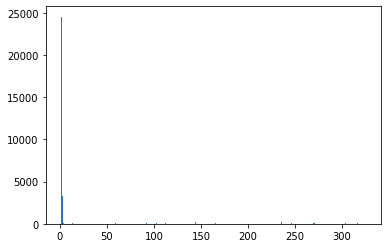

In [21]:
plt.hist(train.data_source, bins=325)
plt.show()

We observed that 78% of the dataset corresponds to one unique data source.  

Although this feature (`data source`) is interesting to explore how the data was obtained, it contains a large number of null values (NA) and is not essential to the main goal of this project (**to predict `tm`**).
So, it was decided to drop this column from the dataset (presented further ahead).

#### Swap pH e tm (to correct data)

Here it was possible to verify that the `pH` variable has errors in the `train` dataset since its maximum is 64.9 (impossible pH value to obtain). According to the [source of the competition](https://www.kaggle.com/competitions/novozymes-enzyme-stability-prediction/discussion/356251), the variable `pH` and `tm` has some samples with the values swapped. Thus, it was necessary to change these values in the identified sequences (dataset `train_updates`).

In [22]:
update_train = pd.read_csv("train_updates_20220929.csv",index_col="seq_id")
train = swap_ph_tm(train,update_train)

In [23]:
print(f"Labels: {[labels for labels in train.columns]}")
print(f"Labels: {[labels for labels in validation.columns]}")

Labels: ['protein_sequence', 'pH', 'data_source', 'tm']
Labels: ['protein_sequence', 'pH', 'data_source']


#### Drop NA Values

As said above, the column `data_source` will be eliminated from the dataset, as well as the rest of the samples with null values.

In [24]:
print("Remove data_source")
train = train.drop(columns="data_source")
validation = validation.drop(columns="data_source")
print(f"Train data is divided in {train.shape[0]} lines and {train.shape[1]} col")
print(f"Validation data is divided in {validation.shape[0]} lines and {validation.shape[1]} col")
print("We want to predict tm values for test data")

Remove data_source
Train data is divided in 28981 lines and 3 col
Validation data is divided in 2413 lines and 2 col
We want to predict tm values for test data


In [25]:
print(train.isnull().sum().sort_values(ascending=False))
print(validation.isnull().sum().sort_values(ascending=False))

pH                  286
protein_sequence      0
tm                    0
dtype: int64
protein_sequence    0
pH                  0
dtype: int64


In [26]:
missing_data = train[train["pH"].isnull()]
# missing_data

In [27]:
train= train.drop((missing_data).index).reset_index(drop=True)
train

,protein_sequence,pH,tm
0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,75.7
1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,50.5
2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,40.5
3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,47.2
4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,49.5
...,...,...,...
28690,YYMYSGGGSALAAGGGGAGRKGDWNDIDSIKKKDLHHSRGDEKAQG...,7.0,51.8
28691,YYNDQHRLSSYSVETAMFLSWERAIVKPGAMFKKAVIGFNCNVDLI...,7.0,37.2
28692,YYQRTLGAELLYKISFGEMPKSAQDSAENCPSGMQFPDTAIAHANV...,7.0,64.6
28693,YYSFSDNITTVFLSRQAIDDDHSLSLGTISDVVESENGVVAADDAR...,7.0,50.7


In [28]:
print(train.isnull().sum().sort_values(ascending=False))
print(validation.isnull().sum().sort_values(ascending=False))

protein_sequence    0
pH                  0
tm                  0
dtype: int64
protein_sequence    0
pH                  0
dtype: int64


#### Summary

In [29]:
# Tamanho das sequencias de proteina e distribuição
lista = [len(train['protein_sequence'].iat[i]) for i in range(len(train))]
pd.Series(lista).describe()

count    28695.000000
mean       451.729535
std        416.889872
min          5.000000
25%        210.000000
50%        352.000000
75%        537.000000
max       8798.000000
dtype: float64

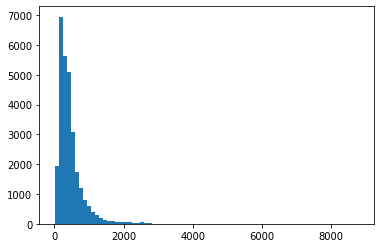

In [30]:
plt.hist(lista, bins=75)
plt.show()

#adicionar titulos aos eixos e grafico

In [31]:
train.describe()

,pH,tm
count,28695.000000,28695.000000
mean,6.872467,51.385604
std,0.793184,12.076609
min,1.990000,25.100000
25%,7.000000,43.700000
50%,7.000000,48.800000
75%,7.000000,54.600000
max,11.000000,130.000000


In [32]:
print(f"Train data is divided in {train.shape[0]} samples and {train.shape[1]} features")
print(f"Labels for train: {[labels for labels in train.columns]}")

Train data is divided in 28695 samples and 3 features
Labels for train: ['protein_sequence', 'pH', 'tm']


Now, other observations can be made:

- the `train` dataset without null values has a total of 28695 samples and only 3 features: `protein_sequence`, `pH`, and `tm`.
- the `pH` feature has values between 1.9 and 11 but, the majority of samples have a pH value of 7.
- the `tm` feature has values between 25 and 130, but 50% of samples have a smaller range: 44-55.
- the `protein_sequence` samples have a large range of lengths (between 5 and 8798), but 50% of samples have lengths between 210 and 537). The mean length of the 28695 sequences is 451.
- to use some machine learning techniques it is needed to transform the feature `protein_sequence` into descriptors (multiple features). 

<a class="anchor" id="section2_4"></a>

### 2.4 Protein Descriptors

As we only have two features to work within the ML step, and one of them is the protein sequence, we need to extract from these sequences a set of descriptors.

Protein descriptors are quantitative measures that characterize various properties of a protein, such as its structure, stability, or function.

Here is a set of examples for these descriptors:

*   Sequence length (1 feature)
*   Amonoacid composition (20 features)
*   dipeptide composition (400 features)
*   tripeptide composition (8000 features)
*   Molecular weight (1 feature)
*   Aromaticity (1 feature)
*   Instability index ( 1 feature)
*   Isoeletric point (1 feature)

The only useful variable for this stage is the `protein_sequence`.
With this data, functions based on the `propy` and `biopython` packages were used:
- `calculate_dipeptide_composition`: DPC - dipeptide composition descriptors (400) for each protein. [propy package](https://pypi.org/project/propy3/)
- `calculate_molecular_weight`: Calculate MW from the Protein sequence. [Biopython](https://biopython.org/docs/1.76/api/Bio.SeqUtils.ProtParam.html)
- `calculate_isoelectric_point`: Uses the module IsoelectricPoint to calculate the pI of a protein. [Biopython](https://biopython.org/docs/1.76/api/Bio.SeqUtils.ProtParam.html)
- `calculate_aromaticity`: Calculates the aromaticity value of a protein according to Lobry, 1994. It is simply the relative frequency of Phe+Trp+Tyr. [Biopython](https://biopython.org/docs/1.76/api/Bio.SeqUtils.ProtParam.html)
- `calculate_instability_index`: Implementation of the method of Guruprasad et al. 1990 to test a protein for stability. Any value above 40 means the protein is unstable. [Biopython](https://biopython.org/docs/1.76/api/Bio.SeqUtils.ProtParam.html)



In [33]:
train_array = np.array(train.loc[:,["protein_sequence"]])

In [34]:
# Calculate dipeptide
di_peptide = calculate_dipeptide_composition(train_array)
di_dataframe= pd.DataFrame(di_peptide)
#Calulate molecular_weight
molecular_weight = calculate_molecular_weight(train_array)
#Calulate isoelectric_point
isoelectric_point = calculate_isoelectric_point(train_array)
#Calulate aromaticity
aromaticity = calculate_aromaticity(train_array)
#Calulate instability_index
instability_index = calculate_instability_index(train_array)

In [35]:
#Add all new features
train["molecular_weight"]=molecular_weight
train["isoelectric_point"]=isoelectric_point
train["aromaticity"]=aromaticity
train["instability_index"]=instability_index

In [36]:
# from propy import PyPro

# def calculate_tri(train_array: pd.DataFrame) -> np.ndarray:
#     """CalculatesTripeptideComposition for len(tran_array["protein_sequence"])
#     Args:
#         train_array (pd.DataFrame): _description_

#     Returns:
#         np.ndarray: _description_
#     """
    
#     final = []
#     for i in train_array:
#         protein = "".join(i)
#         result = PyPro.GetSpectrumDict(protein)
#         final.append(result)

#     return final


In [37]:
#tripeptide= calculate_tri(train_array)

In [38]:
train_dataset = train.join(di_dataframe)
train_dataset.sample()

,protein_sequence,pH,tm,molecular_weight,isoelectric_point,aromaticity,instability_index,AA,AR,AN,...,VL,VK,VM,VF,VP,VS,VT,VW,VY,VV
12122,MIRFILIQNRAGKTRLAKWYMHFDDDEKQKLIEEVHACVTVRDAKH...,7.0,39.6,16953.479,6.1957,0.148936,28.39227,0.0,0.0,0.0,...,1.43,0.0,0.0,0.71,0.0,0.0,0.71,0.0,1.43,0.71


In [39]:
train_y= train["tm"]
train_y

0        75.7
1        50.5
2        40.5
3        47.2
4        49.5
         ... 
28690    51.8
28691    37.2
28692    64.6
28693    50.7
28694    37.6
Name: tm, Length: 28695, dtype: float64

In [40]:
train_dataset

,protein_sequence,pH,tm,molecular_weight,isoelectric_point,aromaticity,instability_index,AA,AR,AN,...,VL,VK,VM,VF,VP,VS,VT,VW,VY,VV
0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,75.7,36320.7244,6.109589,0.058651,28.389736,2.35,0.88,0.29,...,0.88,0.29,0.00,0.29,0.59,0.29,1.18,0.00,0.29,1.76
1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,50.5,32837.9931,5.144349,0.041958,65.108392,0.70,0.70,0.35,...,0.35,0.00,0.00,0.00,0.00,0.70,0.00,0.00,0.00,0.70
2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,40.5,53428.8034,9.032101,0.080483,35.089336,1.21,0.20,0.40,...,0.40,0.20,0.40,0.00,0.60,0.40,0.40,0.00,0.20,0.20
3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,47.2,29475.5996,4.683840,0.071698,50.502264,0.38,0.38,0.00,...,0.38,0.38,0.00,0.00,0.38,0.38,0.76,0.00,0.00,0.38
4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,49.5,158761.9814,5.917928,0.065472,45.668808,0.28,0.14,0.34,...,0.34,0.48,0.21,0.28,0.62,0.55,0.83,0.00,0.14,0.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28690,YYMYSGGGSALAAGGGGAGRKGDWNDIDSIKKKDLHHSRGDEKAQG...,7.0,51.8,61997.6230,8.466327,0.089253,48.604026,0.73,0.73,0.00,...,0.55,0.18,0.18,0.55,0.55,0.36,0.00,0.55,0.18,0.91
28691,YYNDQHRLSSYSVETAMFLSWERAIVKPGAMFKKAVIGFNCNVDLI...,7.0,37.2,52637.6897,6.532244,0.087420,35.285096,1.07,0.21,0.85,...,0.64,0.43,0.21,0.21,0.21,0.43,0.00,0.00,0.21,0.85
28692,YYQRTLGAELLYKISFGEMPKSAQDSAENCPSGMQFPDTAIAHANV...,7.0,64.6,14203.9225,5.271214,0.117188,44.198437,0.79,0.00,1.57,...,0.79,0.79,0.00,0.00,0.79,0.00,0.79,0.00,0.00,0.79
28693,YYSFSDNITTVFLSRQAIDDDHSLSLGTISDVVESENGVVAADDAR...,7.0,50.7,64367.8724,5.688128,0.074199,36.618398,1.01,0.68,0.00,...,1.01,0.34,0.34,0.51,0.17,0.84,0.34,0.00,0.17,1.01


Now, the dataset has 407 variables.

<a class="anchor" id="section2_5"></a>

### 2.5 Embedding

An embedding is a relatively low-dimensional space that can be translated into high-dimensional vectors. This type of preprocessing make it easier to do machine learning on large inputs like sparse vectors representing protein sequences.

#### SGT Embedding

This type of embedding embeds long patterns, in this case, long protein patterns, into a finite-dimension vector. The main advantage of SGT is that the long and short-term patterns embedded in SGT can be tuned without any increase in the computation. [GitHub source](https://github.com/cran2367/sgt.git)

`kappa` --> Tuning parameter, kappa > 0, to change the extraction of long-term dependency. Higher the value the lesser the long-term dependency captured in the embedding. Typical values for kappa are 1, 5, and 10.

`lengthsensitive` -->  Default false. This is set to true if the embedding should have the information on the length of the sequence. If set to false then the embedding of two sequences with similar patterns but different lengths will be the same.
lengthsensitive = false is similar to length-normalization.


In [ ]:
# #Get protein sequence with seq_id 
# corpus= train.copy()
# corpus['protein_sequence'] = corpus['protein_sequence'].map(list)
# ids= np.array([i for i in range(len(corpus['protein_sequence']))])
# corpus=corpus[['protein_sequence']]
# corpus.insert(0, 'ids', ids)
# corpus.columns = ['id', 'sequence']
# corpus.sample(1)

In [ ]:
# sgt = SGT(kappa=1, 
#            lengthsensitive=False, 
#            mode='multiprocessing')
# embeddings = sgt.fit_transform(corpus)
# embeddings.sample()

# embeddings['id'] = embeddings['id'].astype('int32')
# embeddings.sample()

In [ ]:
# train_dataset_embedding = train.join(embeddings)

<a class="anchor" id="section2_6"></a>

### 2.6 Preprocessing

Here, the `protein_sequence` column has been deleted, since it is a qualitative variable and cannot be used for data preprocessing. The `tm` column was also removed because it is the target variable that we want to predict in the following analysis.

To make the data internally consistent, it was standardized with the scale function of the sklearn package.

After standardizing the data, the dataset was divided into:
- train, with 70% of the samples
- test, with 30% of the samples

For this division, a permutation of the data was performed so that the data have a similar representation in the training and test dataset.

#### Variavel para LSTM

In [41]:
train_data = train_dataset

In [42]:
num_test = int(train_data.shape[0] * 0.3)

print("Número de exemplos para teste:", num_test)

# Get the Input data randomly (70%)

train_70_prot = train_data.sample(frac = 0.7)
 
# Creating dataframe with rest 30% values
train_30_prot = train_data.drop(train_70_prot.index)

# Get the output data (removing tm variable)
train_out = train_70_prot["tm"]
train_in = train_70_prot.drop(columns= ["tm"])

Número de exemplos para teste: 8608


#### Variavel para resto de ML

In [53]:
# Dataset for Supervised ML usage
train_dataset_ml = deepcopy(train_dataset)

# Dataset for Unsupervised ML usage
train_dataset= train_dataset.drop(columns= ["protein_sequence","tm"])

In [54]:
# train_dataset_embedding= train_dataset_embedding.drop(columns=["protein_sequence"])

In [55]:
train_dataset

,pH,molecular_weight,isoelectric_point,aromaticity,instability_index,AA,AR,AN,AD,AC,...,VL,VK,VM,VF,VP,VS,VT,VW,VY,VV
0,7.0,36320.7244,6.109589,0.058651,28.389736,2.35,0.88,0.29,0.29,0.00,...,0.88,0.29,0.00,0.29,0.59,0.29,1.18,0.00,0.29,1.76
1,7.0,32837.9931,5.144349,0.041958,65.108392,0.70,0.70,0.35,0.35,0.00,...,0.35,0.00,0.00,0.00,0.00,0.70,0.00,0.00,0.00,0.70
2,7.0,53428.8034,9.032101,0.080483,35.089336,1.21,0.20,0.40,0.60,0.00,...,0.40,0.20,0.40,0.00,0.60,0.40,0.40,0.00,0.20,0.20
3,7.0,29475.5996,4.683840,0.071698,50.502264,0.38,0.38,0.00,0.76,0.38,...,0.38,0.38,0.00,0.00,0.38,0.38,0.76,0.00,0.00,0.38
4,7.0,158761.9814,5.917928,0.065472,45.668808,0.28,0.14,0.34,0.28,0.07,...,0.34,0.48,0.21,0.28,0.62,0.55,0.83,0.00,0.14,0.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28690,7.0,61997.6230,8.466327,0.089253,48.604026,0.73,0.73,0.00,0.55,0.00,...,0.55,0.18,0.18,0.55,0.55,0.36,0.00,0.55,0.18,0.91
28691,7.0,52637.6897,6.532244,0.087420,35.285096,1.07,0.21,0.85,0.64,0.00,...,0.64,0.43,0.21,0.21,0.21,0.43,0.00,0.00,0.21,0.85
28692,7.0,14203.9225,5.271214,0.117188,44.198437,0.79,0.00,1.57,0.00,0.00,...,0.79,0.79,0.00,0.00,0.79,0.00,0.79,0.00,0.00,0.79
28693,7.0,64367.8724,5.688128,0.074199,36.618398,1.01,0.68,0.00,0.34,0.00,...,1.01,0.34,0.34,0.51,0.17,0.84,0.34,0.00,0.17,1.01


In [56]:
pre_processed_data = preprocessing.scale(train_dataset)

print("Media global: ", pre_processed_data.mean())
print("Desvio padrao global: ", pre_processed_data.std())
print("\nVerificar se a média e o desvio padrão estão próximos dos valores 0 e 1, respetivamente.")
print("\tMédia:", ((pre_processed_data.mean(axis=0) < 0.000001) & (pre_processed_data.mean(axis=0) > -0.000001)).all())
print("\tDesvio Padrão:", ((pre_processed_data.std(axis=0) < 1.000001) & (pre_processed_data.std(axis=0) > 0.999999)).all())

Media global:  -4.803197298218468e-18
Desvio padrao global:  1.0000000000000002

Verificar se a média e o desvio padrão estão próximos dos valores 0 e 1, respetivamente.
	Média: True
	Desvio Padrão: True


In [57]:
pre_processed_data

array([[ 0.16078851, -0.30259299, -0.38866605, ..., -0.41899083,
         0.26036277,  3.05330905],
       [ 0.16078851, -0.37740901, -0.95272322, ..., -0.41899083,
        -0.74319537,  0.6127002 ],
       [ 0.16078851,  0.06492272,  1.31916243, ..., -0.41899083,
        -0.05108631, -0.53853038],
       ...,
       [ 0.16078851, -0.77770607, -0.87858734, ..., -0.41899083,
        -0.74319537,  0.81992171],
       [ 0.16078851,  0.29991577, -0.63495529, ..., -0.41899083,
        -0.15490267,  1.32646317],
       [ 0.16078851,  0.25490064,  0.21338908, ...,  0.73706128,
         0.5372064 ,  0.29035564]])

In [58]:
num_test = int(pre_processed_data.shape[0] * 0.3)

print("Número de exemplos para teste:", num_test)

indices = np.random.permutation(len(train_dataset))

# Get the Input data pre-processed according with the indexes
train_input = pre_processed_data[indices[:-num_test]]
test_input = pre_processed_data[indices[-num_test:]]

# Get the output data according with the indexes
train_output = train_y[indices[:-num_test]]
test_output = train_y[indices[-num_test:]]

Número de exemplos para teste: 8608


In [59]:
# pre_processed_data_embeddings = preprocessing.scale(train_dataset_embedding)

# print("Media global: ", pre_processed_data.mean())
# print("Desvio padrao global: ", pre_processed_data.std())
# print("\nVerificar se a média e o desvio padrão estão próximos dos valores 0 e 1, respetivamente.")
# print("\tMédia:", ((pre_processed_data.mean(axis=0) < 0.000001) & (pre_processed_data.mean(axis=0) > -0.000001)).all())
# print("\tDesvio Padrão:", ((pre_processed_data.std(axis=0) < 1.000001) & (pre_processed_data.std(axis=0) > 0.999999)).all())


# num_test = int(pre_processed_data_embeddings.shape[0] * 0.3)

# print("Numero de exemplos para teste: ", num_test)

# indices = np.random.permutation(len(train_dataset))

# # Get the Input data pre-processed according with the indexes
# train_input_embedding = pre_processed_data_embeddings[indices[:-num_test]]
# test_input_embedding= pre_processed_data_embeddings[indices[-num_test:]]

# # Get the output data according with the indexes
# train_output_embedding = train_y[indices[:-num_test]]
# test_output_embedding = train_y[indices[-num_test:]]

In [63]:
train_output.shape

(20087,)

<a class="anchor" id="chapter3"></a>

## 3. Non-Supervised Analysis

Unsupervised machine learning is a type of ML where we don't give any labels to the model. Instead, the model is only given input data and must find patterns or relationships in the data on its own. 

Some common unsupervised learning techniques include clustering and dimensionality reduction.

<a class="anchor" id="section3_1"></a>

### 3.1 PCA

Principal component analysis (PCA) serves as a dimensionality reduction method, often used to reduce dimensions of large data sets, by transforming a large set of variables into a smaller one, reducing accuracy, but still containing most of the needed information.

1. Standardize the range of continuous initial variables (Previously done)
2. Compute the covariance matrix to identify correlations
3. Compute the eigenvectors and eigenvalues of the covariance matrix to identify the principal components
4. Recast the data along the axes of the principal component

It was made PCA for the dataset with and without the embeddings.

[0.03405566 0.02448643 0.02153552 0.01789637 0.01616384 0.0142188
 0.0128461  0.01259442 0.01176795 0.01109273 0.01060656 0.01001765
 0.00967158 0.00888073 0.00858789]
0.22442224580926198
90.97181398794457


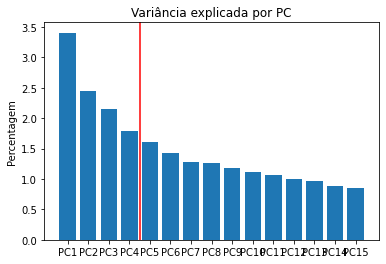

In [ ]:
#Select the number of components 
n=15

pca_train= PCA(n_components=n)
pca_train.fit_transform(train_input)

print(pca_train.explained_variance_ratio_)
print(np.sum(pca_train.explained_variance_ratio_))
print(np.sum(pca_train.explained_variance_))

plt.bar(range(n), pca_train.explained_variance_ratio_*100)
plt.xticks(range(n), ['PC'+str(i) for i in range(1,n+1)])
plt.title("Variância explicada por PC")
plt.ylabel("Percentagem")
plt.axvline(3.5, color='r') # vertical
plt.show()


In [ ]:
# # Embeddings
# pca_train= PCA(n_components=n)
# pca_train.fit_transform(train_input_embedding)

# print(pca_train.explained_variance_ratio_)
# print(np.sum(pca_train.explained_variance_ratio_))
# print(np.sum(pca_train.explained_variance_))

# plt.bar(range(n), pca_train.explained_variance_ratio_*100)
# plt.xticks(range(n), ['PC'+str(i) for i in range(1,n+1)])
# plt.title("Variância explicada por PC with embeddings")
# plt.ylabel("Percentagem")
# plt.axvline(3.5, color='r') # vertical
# plt.show()

In both cases, PCA doesn't return a significantly explained variance. In each case, the explained variance ratio is around 22% with the explained variance being higher in the embeddings.

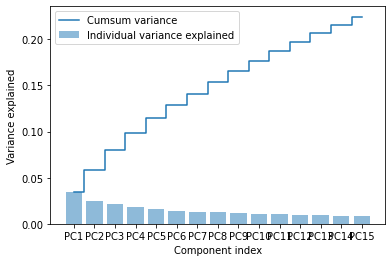

In [ ]:
n=15
pca = PCA(n_components=n)
X= pca.fit_transform(train_input)
df_pca = pd.DataFrame(data=X)

features = range(pca.n_components_)
exp_var_pca = pca.explained_variance_ratio_
cumsum = np.cumsum(exp_var_pca)   
explained_variance = pca.explained_variance_


plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual variance explained')
plt.step(range(0,len(cumsum)), cumsum, where='mid',label='Cumsum variance')
plt.xticks(range(n), ['PC'+str(i) for i in range(1,n+1)])
plt.ylabel("Variance explained")
plt.xlabel("Component index")
plt.legend(loc='best')
plt.show()

We can conclude that PCA is not effective

<a class="anchor" id="section3_2"></a>

### 3.2 Kmeans

K-Means is an unsupervised machine learning algorithm used to group data into clusters based on similarities.
The goal of K-means is to partition a dataset into a specified number of clusters (k) in a way that minimizes the within-cluster sum of squares. Here we present the following steps to run this algorithm:

1. Randomly selecting k initial centroids (points in the dataset that represent the center of the clusters)
2. Data point assigned to the cluster corresponding to the nearest centroid
3. The centroids are then updated to be the mean of the points in their respective clusters

This process is repeated until the centroids no longer change, or a maximum number of iterations is reached (In this case we set a maximum number of iterations).

In [ ]:
ph_array=train_input[:, 0]
train_input= train_input[:, 1:]
test_input= test_input[:, 1:]

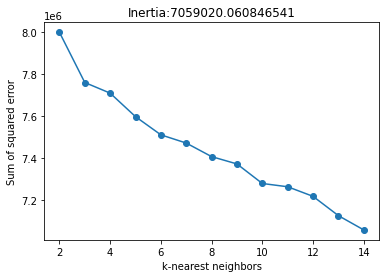

In [ ]:
#Without embeding 
k=list(range(2,15))
ssd=[]
for i in k:
    kmeans=KMeans(n_clusters=i).fit(train_input)
    ssd.append(kmeans.inertia_)
    
plt.plot(k, ssd, 'o-')
plt.xlabel('k-nearest neighbors')
plt.ylabel('Sum of squared error')
ii=kmeans.inertia_
plt.title('Inertia:{}'.format(ii))
plt.show()
#inertia is a measure of the sum of squared distances of all the points within a cluster to its centroid.

In [ ]:
# #with embeding 

# k=list(range(2,15))
# ssd=[]
# for i in k:
#     kmeans=KMeans(n_clusters=i).fit(train_input_embedding)
#     ssd.append(kmeans.inertia_)
    
# plt.plot(k, ssd, 'o-')
# plt.xlabel('k-nearest neighbors')
# plt.ylabel('Sum of squared error')
# ii=kmeans.inertia_
# plt.title('Inertia:{}'.format(ii))
# plt.show()

In [ ]:
#Lets try this
kmeans_train= KMeans(n_clusters=15,max_iter=1000).fit(train_input)
kmeans_result=kmeans_train.predict(test_input)
inertia=kmeans_train.inertia_
#Give a variable to the centroids and labels 
centroids= kmeans_train.cluster_centers_
labels= kmeans_train.labels_



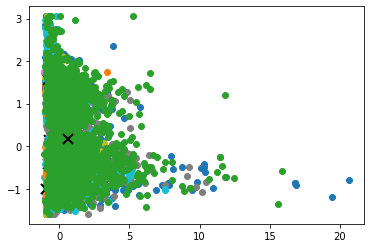

In [ ]:
for i in range(len(k)):
    # select only data observations with cluster label == i
    ds = train_input[np.where(labels==i)]
    # plot the data observations (only 2 first colums)
    plt.plot(ds[:,0],ds[:,1],'o')
    # plot the centroids
    lines = plt.plot(centroids[i,0],centroids[i,1],'kx')
    # make the centroid x's bigger
    plt.setp(lines,ms=10.0)    # x size 
    plt.setp(lines,mew=2.0)    #grossura da linha
plt.show()

As we can see, the graph shows at the top a high inertia, meaning a high sum of squared distances. The quality of these clusters are low.

### t-SNE

t-SNE (t-Distributed Stochastic Neighbor Embedding) is used to project high-dimensional data into a lower-dimensional space, typically 2 or 3 dimensions. The goal is to preserve the pairwise distances between the data points in the lower-dimensional space as much as possible.

1. Compute pairwise affinities between all data points in the high-dimensional space.
2. Use these affinities to construct a probability distribution over the data points in the high-dimensional space.
3. Embed the data points in the low-dimensional space by minimizing the divergence between the two probability distributions (i.e., the one in the high-dimensional space and the one in the low-dimensional space).
4. Repeat steps 1-3 for a number of iterations until the embedding has stabilized.

In [ ]:
tsne = TSNE(n_components=2, n_iter=1000,perplexity=40)
points = tsne.fit_transform(train_input)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


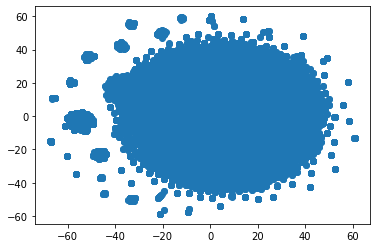

In [ ]:
plt.scatter(points[:,0],points[:,1])


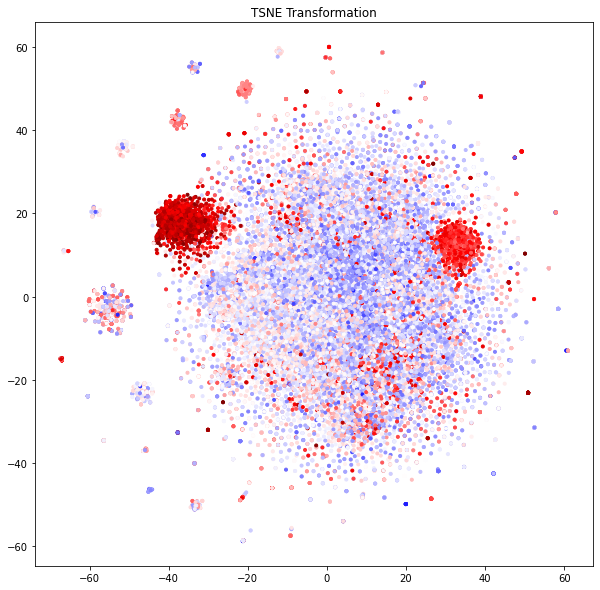

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.figure(figsize=(10,10))
norm = Normalize(vmin=0, vmax=100)
plt.scatter(points[:,0], points[:,1], c=train_output, cmap=cm.get_cmap('seismic'), marker='.', norm=norm)
plt.title('TSNE Transformation')
plt.show()
plt.savefig('creature.png')

Here we can see clusters with colors related to the thermostability of the proteins, the red ones are the ones with the highest stability index.

<a class="anchor" id="chapter4"></a>

## 4. Supervised Machine Learning

Supervised Machine Learning has the distinct characteristic of being trained on a labeled dataset. Hereon, the same training dataset of the unsupervised ML will be used with the correct output labeled.

<a class="anchor" id="section4_1"></a>

### 4.1 Regression Analysis

The algorithm, through the recognition of patterns in the training data, will provide predictions in new unseen data. 

SupervisedModelOptimization class was built under the utils/models.py file and uses several useful Supervised Machine Learning models in regression problems, which represents our current task. This class allows the fit of predefined models with the tuning of the possible important hyper-parameters variations, by the fit_model() method. Finally, a prediction with the tuned and fitted model may be proceeded with the predict() method (check class documentation for further details).

Pre-processing and verification of the mean and standard deviation of the train dataset:

In [ ]:
data_input = train_dataset_ml.loc[:, ~train_dataset_ml.columns.isin(["protein_sequence", "tm"])].values
data_output = train_dataset_ml.loc[:, "tm"].values

data_input = preprocessing.scale(data_input)

print("Media global: ", data_input.mean())
print("Desvio padrao global: ", data_input.std())
print("\nVerificar se a média e o desvio padrão estão próximos dos valores 0 e 1, respetivamente.")
print("\tMédia:", ((data_input.mean(axis=0) < 0.000001) & (data_input.mean(axis=0) > -0.000001)).all())
print("\tDesvio Padrão:", ((data_input.std(axis=0) < 1.000001) & (data_input.std(axis=0) > 0.999999)).all())

Media global:  -4.803197298218468e-18
Desvio padrao global:  1.0000000000000002

Verificar se a média e o desvio padrão estão próximos dos valores 0 e 1, respetivamente.
	Média: True
	Desvio Padrão: True


In [ ]:
# Current possible models
# SVM Removed due to the time taking to run
#models = ["Linear Regression", "KNN", "Bagging", "SVM",  "Decision Tree", "Random Forest"]
models = ["Linear Regression", "KNN", "Bagging",  "Random Forest", "Decision Tree"]

# Class instance
smo = SupervisedModelOptimization(data_input, data_output)
smo.summary()

No assigned test data, splitting the inputted train data
Input and output training Dimensions: (20086, 405) (20086,)
Input and output testing Dimensions: (8609, 405) (8609,)


Herewith, the class SupervisedModelOptimization splits the data automatically by a 0.3 proportion if no assigned test data. Accordingly, we have 20086 training samples and 8609 testing samples. 

In [ ]:
model_scores = {}

for model in models:
  print(f"Running {model} prediction...")
  # Fit the model
  smo.fit_model(method=model, cross_val=5)
  
  # Get the predictions
  predictions = smo.predict()
  
  # Get the score
  score = smo.score()
  
  smo.summary()
  
  # Store in the global variable
  model_scores[model] = (predictions, score)

Running Linear Regression prediction...
Input and output training Dimensions: (20086, 405) (20086,)
Input and output testing Dimensions: (8609, 405) (8609,)

Model: LinearRegression

**First 10 Values Previsions**
Testing values | Model predictions
62.0 | 48.59071258831894
45.5 | 42.83319010933952
40.9 | 54.63256797479969
38.7 | 51.839283267946854
35.5 | 47.53587976657254
66.1 | 54.259715209313036
54.7 | 59.65966504728884
52.0 | 52.89198560694653
51.5 | 50.697936355588986
49.9 | 48.022959556175095

**Results**
Best parameters set found on development set: 
 None
Best/lowest score (Root Mean Squared Error): 
 9.321605133229363
Running KNN prediction...


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Input and output training Dimensions: (20086, 405) (20086,)
Input and output testing Dimensions: (8609, 405) (8609,)

Model: KNeighborsRegressor

**First 10 Values Previsions**
Testing values | Model predictions
62.0 | 53.720000000000006
45.5 | 41.5
40.9 | 43.93999999999999
38.7 | 43.17999999999999
35.5 | 41.14
66.1 | 64.12
54.7 | 55.96
52.0 | 53.220000000000006
51.5 | 53.15999999999999
49.9 | 47.86

**Results**
Best parameters set found on development set: 
 {'n_neighbors': 5}
Best/lowest score (Root Mean Squared Error): 
 8.44592552570935
Running Bagging prediction...


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Input and output training Dimensions: (20086, 405) (20086,)
Input and output testing Dimensions: (8609, 405) (8609,)

Model: BaggingRegressor

**First 10 Values Previsions**
Testing values | Model predictions
62.0 | 54.11999999999998
45.5 | 50.03
40.9 | 57.080000000000005
38.7 | 50.89000000000001
35.5 | 43.82000000000001
66.1 | 64.89500000000001
54.7 | 53.489999999999995
52.0 | 55.160000000000004
51.5 | 51.96
49.9 | 45.559999999999995

**Results**
Best parameters set found on development set: 
 {'max_samples': 0.5, 'bootstrap': False}
Best/lowest score (Root Mean Squared Error): 
 8.892788154375804
Running Random Forest prediction...


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Input and output training Dimensions: (20086, 405) (20086,)
Input and output testing Dimensions: (8609, 405) (8609,)

Model: RandomForestRegressor

**First 10 Values Previsions**
Testing values | Model predictions
62.0 | 52.61783333333332
45.5 | 47.47599999999999
40.9 | 49.29900000000002
38.7 | 47.35099999999999
35.5 | 45.817000000000014
66.1 | 64.97241666666666
54.7 | 52.64300000000002
52.0 | 51.43066666666667
51.5 | 52.487666666666684
49.9 | 47.855499999999985

**Results**
Best parameters set found on development set: 
 {'n_estimators': 100, 'max_depth': 100}
Best/lowest score (Root Mean Squared Error): 
 8.387996591333751
Running Decision Tree prediction...


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Input and output training Dimensions: (20086, 405) (20086,)
Input and output testing Dimensions: (8609, 405) (8609,)

Model: DecisionTreeRegressor

**First 10 Values Previsions**
Testing values | Model predictions
62.0 | 47.90708929107076
45.5 | 47.90708929107076
40.9 | 51.18581103962091
38.7 | 47.90708929107076
35.5 | 47.90708929107076
66.1 | 50.37700642054585
54.7 | 47.90708929107076
52.0 | 50.37700642054585
51.5 | 56.15846774193548
49.9 | 47.90708929107076

**Results**
Best parameters set found on development set: 
 {'max_depth': 5}
Best/lowest score (Root Mean Squared Error): 
 10.317757538697911


In [ ]:
for model, values in model_scores.items():
  predictions, score = values
  print(f"{model} obtained the following Root Mean Squared Error:\n\t{score}\n")

Linear Regression obtained the following Root Mean Squared Error:
	9.321605133229363

KNN obtained the following Root Mean Squared Error:
	8.44592552570935

Bagging obtained the following Root Mean Squared Error:
	8.892788154375804

Random Forest obtained the following Root Mean Squared Error:
	8.387996591333751

Decision Tree obtained the following Root Mean Squared Error:
	10.317757538697911



We verify that the Root Mean Squared Error (RMSE) remained between 8 and 10 except for the Decision Tree Regressor, resulting in a 10.31 value error. 

Herewith, Supervised Machine Learning demonstrated better results than Unsupervised, but far from desired. Random Forest (RF) is the best model due to having the lowest RMSE (8.388), using the following parameters:  
    
    {'n_estimators': 100, 'max_depth': 50}.

It corresponds to the maximum number of estimators and depth attributed. Therefore, model improvement may occur with increased values in these parameters. However, the processing time increases immensely with the increased parameter values, being the error reduction not significant.

In the first analysis, the cross-validation value remained at a value of 2 to reduce at max the training time. With this, RF exhibited an RMSE value of 8.400. The number of cross-validations was increased to 5 and obtained a value of 8.388, indicating little to no improvement.

Despite several attempts to run the Support Vector Regression model, it eventually got removed from the equation owing to running endlessly.

### 4.2. Binary Analysis

In this section, we predicted the stability of a protein sequence. Protein sequences are stable if the Tm of a protein sequence is above 65◦C (Tm > 65◦C). Thus, a binary prediction through Logistic Regression will inform us of the relevant stable protein sequences. [Source Article here.](https://doi.org/10.1016/j.compbiolchem.2009.10.002)

In [ ]:
data_input

array([[ 0.16078851, -0.30259299, -0.38866605, ..., -0.41899083,
         0.26036277,  3.05330905],
       [ 0.16078851, -0.37740901, -0.95272322, ..., -0.41899083,
        -0.74319537,  0.6127002 ],
       [ 0.16078851,  0.06492272,  1.31916243, ..., -0.41899083,
        -0.05108631, -0.53853038],
       ...,
       [ 0.16078851, -0.77770607, -0.87858734, ..., -0.41899083,
        -0.74319537,  0.81992171],
       [ 0.16078851,  0.29991577, -0.63495529, ..., -0.41899083,
        -0.15490267,  1.32646317],
       [ 0.16078851,  0.25490064,  0.21338908, ...,  0.73706128,
         0.5372064 ,  0.29035564]])

In [ ]:
data_output

array([75.7, 50.5, 40.5, ..., 64.6, 50.7, 37.6])

In [ ]:
# Train and test data division
train_input, test_input, train_output, test_output = train_test_split(data_input, data_output, test_size=0.3, random_state=42)

In [ ]:
print("Train data:")
print(train_input)
print(train_output)
print("Test data:")
print(test_input)
print(test_output)

Train data:
[[ 0.16078851 -0.16972575 -0.756954   ... -0.41899083  0.15654641
   0.2212818 ]
 [ 0.16078851  1.95356433  0.7044457  ... -0.41899083 -0.22411357
  -0.99902262]
 [ 0.16078851 -0.85565244 -1.30825661 ... -0.41899083 -0.74319537
   1.41856161]
 ...
 [ 0.16078851 -0.18314266  1.35129784 ...  1.28466491  0.22575732
  -0.99902262]
 [ 0.16078851  0.00914667  0.54716664 ... -0.41899083  0.81405002
   0.54362637]
 [ 0.16078851 -0.62054478  1.83788737 ... -0.41899083  1.09089365
  -0.99902262]]
[47.5 64.9 48.6 ... 51.  40.3 42.7]
Test data:
[[-1.09997477 -0.73008606  1.25952545 ... -0.41899083 -0.74319537
  -0.99902262]
 [ 0.16078851 -0.10740628 -0.6934137  ... -0.41899083  0.12194096
  -0.99902262]
 [ 0.16078851 -0.42753283 -0.39979308 ... -0.41899083  0.50260094
  -0.1701366 ]
 ...
 [ 0.16078851 -0.91282453  1.89142126 ... -0.41899083  4.20538443
  -0.99902262]
 [ 0.16078851  0.96281176 -1.13032384 ...  0.31114734 -0.32792993
  -0.44643194]
 [ 0.16078851  0.97119144  0.82940834 .

In [ ]:
tm_threshold = 65.0

# Define the train output data
binary_train_output = deepcopy(train_output)

mask = binary_train_output >= tm_threshold
binary_train_output[mask] = 1
binary_train_output[~mask] = 0

binary_train_output

array([0., 0., 0., ..., 0., 0., 0.])

In [ ]:
# Define the test output data
binary_test_output = deepcopy(test_output)

mask = binary_test_output >= tm_threshold
binary_test_output[mask] = 1
binary_test_output[~mask] = 0

binary_test_output

array([0., 0., 0., ..., 0., 0., 0.])

In [ ]:
print("Occurrences of each value in train output values:")
unique_train, counts_train = np.unique(binary_train_output, return_counts=True)
print(dict(zip(unique_train, counts_train)))

print()
print("Occurrences of each value in test output values:")
unique_test, counts_test = np.unique(binary_test_output, return_counts=True)
print(dict(zip(unique_test, counts_test)))

Occurrences of each value in train output values:
{0.0: 17487, 1.0: 2599}

Occurrences of each value in test output values:
{0.0: 7566, 1.0: 1043}


Due to the unbalanced data verified by the output occurrences, we are adding the parameter "class_weight" to the LogisticRegression model to adjust the training data. The value for the ratio used is 6 to 1.

In [ ]:
class_weight = {0: 6, 1: 1}

In [ ]:
log_reg = LogisticRegression(solver='liblinear', max_iter=100, class_weight=class_weight)

# Fit the model
log_reg.fit(train_input, binary_train_output)

# Predict values
y_pred = log_reg.predict(test_input)

print("First 10 Predictions:", y_pred[:10])
print("Accuracy Score:", balanced_accuracy_score(binary_test_output, y_pred) * 100)

First 10 Predictions: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Accuracy Score: 67.83496030711143


We achieved a balanced accuracy score of 67.83%. Therefore, we obtained a relatively positive protein stability prediction accuracy from our model. Our biggest issue are the unbalanced data, which the parameter "class_weight" tries to overcome. However, a more balanced data may result in better predictions.

<a class="anchor" id="chapter5"></a>

## 5. Deep Learning

In [48]:
def setup_FFNN(units, activation):
    model = Sequential()
    model.add(Dense(units, activation=activation, input_shape=(train_input.shape[1],)))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation=activation))
    model.add(Dense(1,activation="linear"))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [45]:
def setup_conv1d(layers,kernel_size, filters, activation):
  model = Sequential()
  for _ in range(1,layers):
    model.add(Conv1D(filters, kernel_size=3, 
                    activation='relu', input_shape=(train_input.shape[1], 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))
  model.add(Flatten())
  model.add(Dense(64, activation='relu'))
  model.add(Dense(1,activation="linear"))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

In [76]:
def setup_LSTM(units, dropout,recurrent_dropout):
  model = Sequential()
  model.add(LSTM(units, input_shape=(train_input.shape[1], 1),
                 return_sequences=True, dropout=dropout, recurrent_dropout=recurrent_dropout))
  model.add(Dropout(0.2))
  model.add(LSTM(units))
  model.add(Dense(1,activation="linear"))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

To set up our models, we added dropout layers/batch normalization to avoid overfitting problems. Then, we also used an early stopping to stop our search when our loss stayed the same.

In [46]:
early_stopping = EarlyStopping(monitor='loss', patience=5)

In [47]:
#Parameter grid

#Conv1d
param_dist_conv = {'layers':[3,10],
                  'kernel_size': [3,5],
                  'filters': [32, 64],
                  'activation': ['relu', 'tanh']}
    
param_dist_ff = {'units': [32,64,128],
              'activation': ['relu', 'tanh']}

param_dist_LSTM = {'units': [32, 64, 128],
              'dropout': [0.1, 0.2, 0.3],
              'recurrent_dropout': [0.1, 0.2, 0.3]}

In [77]:
regressor_conv1d = KerasRegressor(build_fn=setup_conv1d, verbose=0, epochs=20, callbacks=[early_stopping])
regressor_ff= KerasRegressor(build_fn=setup_FFNN, verbose=0)
regressor_LSTM= KerasRegressor(build_fn=setup_LSTM, verbose=0)

<ipython-input-77-f5f95fceded1>:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  regressor_conv1d = KerasRegressor(build_fn=setup_conv1d, verbose=0, epochs=20, callbacks=[early_stopping])
<ipython-input-77-f5f95fceded1>:2: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  regressor_ff= KerasRegressor(build_fn=setup_FFNN, verbose=0)
<ipython-input-77-f5f95fceded1>:3: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  regressor_LSTM= KerasRegressor(build_fn=setup_LSTM, verbose=0)


In [78]:
random_search_conv1d = RandomizedSearchCV(regressor_conv1d, param_distributions=param_dist_conv,
                                   n_iter=10, cv=5, verbose=1,
                                   scoring='neg_mean_squared_error',random_state=42)

random_search_ff = RandomizedSearchCV(regressor_ff, param_distributions=param_dist_ff,
                                   n_iter=10, cv=5, verbose=1,
                                   scoring='neg_mean_squared_error',random_state=42)

random_search_LSTM = RandomizedSearchCV(regressor_LSTM, param_distributions=param_dist_LSTM,
                                   n_iter=10, cv=5, verbose=1,
                                   scoring='neg_mean_squared_error',random_state=42)


In [ ]:
history=random_search_conv1d.fit(train_input, train_output)

In [69]:
random_search_ff.fit(train_input, train_output)

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 6 candidates, totalling 30 fits


RandomizedSearchCV(cv=5,
                   estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x7f3addd94250>,
                   param_distributions={'activation': ['relu', 'tanh'],
                                        'units': [32, 64, 128]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=1)

In [ ]:
random_search_LSTM.fit(train_input, train_output)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [66]:
print(history.best_params_)

# Evaluate the model
y_pred = history.predict(test_input)
print("rmse:", mean_squared_error(test_output, y_pred,squared=False))

{'layers': 3, 'kernel_size': 5, 'filters': 32, 'activation': 'relu'}
rmse: 7.942444528722106


Best value of rmse of our models! rmse= 7.94

In [73]:
print(random_search_ff.best_params_)

# Evaluate the model
y_pred = random_search_ff.predict(test_input)
print("rmse:", mean_squared_error(test_output, y_pred,squared=False))

{'units': 128, 'activation': 'relu'}
rmse: 11.819210236244349


In [ ]:
print(random_search_LSTM.best_params_)

# Evaluate the model
y_pred = random_search_LSTM.predict(test_input)
print("rmse:", mean_squared_error(test_output, y_pred,squared=False))

In [74]:
#history for conv

# import matplotlib.pyplot as plt
# print(history.history.keys())
# # summarize history for accuracy
# plt.plot(history.history[ 'loss' ])
# plt.plot(history.history[ 'val_loss' ])
# plt.title( 'model loss' )
# plt.ylabel( 'loss' )
# plt.xlabel( 'epoch' )
# plt.legend([ 'train' , 'test' ], loc= 'upper left' )
# plt.show()

We verified that the Root Mean Squared Error (RMSE) of the best fully connected NN and conv1d was 11.819 {'units': 128, 'activation': 'relu'}
 and 7.94 {'layers': 3, 'kernel_size': 5, 'filters': 32, 'activation': 'relu'}. Our LSTM model was the worst, giving a mse of 147. For the LSTM we stopped trying to improve this model for computation reasons, as it was taking 10+ hours to run, and the initial results of the model were the worst. 

Herewith, Deeplearning demonstrated better results than Unsupervised and Supervised ML, but far from desired. Our conv1d NN was our best model from all our analyses, having a rmse:7.94

<a class="anchor" id="chapter6"></a>

## 6. Conclusions

This work can be summarized in 3 main sections: unsupervised analysis, supervised analysis, and deep learning.

The **unsupervised analysis** consisted of a dimensionality reduction through PCA, clustering through K-means, and t-SNE.
Only in the t-SNE analysis was it possible to observe some clusters based on the thermostability of the proteins, while PCA and K-means did not have conclusive results.

The **supervised analysis - ML** consisted of regression analysis and binary analysis.
In the regression analysis, several models were tested ("Linear Regression", "KNN", "Bagging", "Random Forest", "Decision Tree") and the effectiveness of these models was calculated using the RMSE metric (Root Mean Squared Error). The best model in this analysis was a Random Forest with an RMSE value of 8388.
In the binary analysis, a parameter was added to adjust the data unbalance and an accuracy of 67.835% was obtained. With more balanced data, this analysis would have been more successful.

The **deep learning** analysis consisted of the use of 3 models: FF (Feed Forward Neural Network), Conv1D (Convolution Neural Network), and LSTM (Long-Short Term Memory). However, the latter was giving runtime errors and so it was only possible to obtain a mse value (obtained in an analysis carried out weeks before), which, compared with the mse values of the other models, the LSTM was the worst (mse: 147).
As for the FF model, it obtained a worse value than conv1D and all models of the supervised ML analysis, with a rmse of 11,819.
The conv1D model had the best value in the entire analysis, with a rmse of 7.94.

That said, we can conclude that the best model of this project to predict the thermostability of enzymes was obtained in the deep learning analysis: **conv1D model**.